In [6]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import surprise
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

In [8]:
utente = input("inserisci id utente : NUMERO COMPRESO TRA 0 E 671")
if ((int(utente) > 671) | (int(utente) < 0)):
    print("valore inserito non valido")
else:
    print("id = ", utente)

id =  8


In [9]:
md = pd. read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/movies_metadata.csv')
#md = pd. read_csv('C:/Users/giord/eclipse-SIW/MoviesRecommenderSystems/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


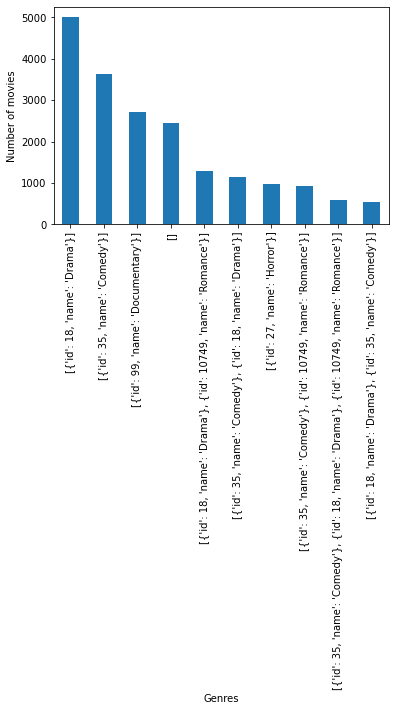

In [10]:
Genres=md.genres
Genres=Genres.apply(pd.Series).stack(level=-1,dropna=True)
Genres.value_counts().head(10).plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.savefig('1.png',dpi=300,bbox_inches='tight')
plt.show()

In [11]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [12]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [13]:
m = vote_counts.quantile(0.95)
m

434.0

In [14]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [16]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [18]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [19]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [20]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [21]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [22]:
build_chart('Animation').head(15)


,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.605761,7.909339
5481,Spirited Away,2001,3968,8,41.048867,7.875933
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.772103
2884,Princess Mononoke,1997,2041,8,17.166725,7.771305
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.735274
40251,Your Name.,2016,1030,8,34.461252,7.589820
5553,Grave of the Fireflies,1988,974,8,0.010902,7.570962
19901,Paperman,2012,734,8,7.198633,7.465676
39386,Piper,2016,487,8,11.243161,7.285132
20779,Wolf Children,2012,483,8,10.249498,7.281198


In [23]:
links_small = pd.read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/links_small.csv')
#links_small = pd. read_csv('C:/Users/giord/eclipse-SIW/MoviesRecommenderSystems/links_small.csv')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [24]:
md = md.drop([19730, 29503, 35587])

In [25]:
md['id'] = md['id'].astype('int')

In [26]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [27]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [28]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [29]:
tfidf_matrix.shape

(9099, 268124)

In [30]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [31]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [32]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [33]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [34]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [35]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [36]:
credits = pd.read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/credits.csv')
keywords = pd.read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/keywords.csv')

#credits = pd. read_csv('C:/Users/giord/eclipse-SIW/MoviesRecommenderSystems/credits.csv')
#keywords = pd. read_csv('C:/Users/giord/eclipse-SIW/MoviesRecommenderSystems/keywords.csv')

ratings = pd.read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/ratings_small.csv')
ratings.head()

,userId,id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [39]:
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
ratings['id'].astype('int')


md = md.merge(credits, on='id')
md = md.merge(ratings, on='id')

In [1]:
'''
tiene conto solo del genere, e successivamente della popolarita e ratings'''
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
ratings['id'].astype('int')


#md = md.merge(credits, on='id')
#md = md.merge(ratings, on='id')



smd = md[md['id'].isin(links_small)]
smd['soup'] = smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])


TypeError: '_Printer' object is not subscriptable

In [ ]:
#keywords['id'] = keywords['id'].astype('int')
#credits['id'] = credits['id'].astype('int')

#md['id'] = md['id'].astype('int') 

In [ ]:
#md.shape

In [ ]:
#md = md.merge(credits, on='id')
#md = md.merge(keywords, on='id')

In [ ]:
#smd = md[md['id'].isin(links_small)]
#smd.shape

In [ ]:
#smd['cast'] = smd['cast'].apply(literal_eval)
#smd['crew'] = smd['crew'].apply(literal_eval)
#smd['keywords'] = smd['keywords'].apply(literal_eval)
#smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
#smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
#smd['director'] = smd['crew'].apply(get_director)

In [ ]:
#smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
#smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
#smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
#smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
#smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [ ]:
#s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
#s.name = 'keyword'

In [ ]:
#s = s.value_counts()
#s[:5]

In [ ]:
#s = s[s > 1]

In [ ]:
#stemmer = SnowballStemmer('english')
#stemmer.stem('dogs')

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
#smd['keywords'] = smd['keywords'].apply(filter_keywords)
#smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
#smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
#smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
#smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
#count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
#count_matrix = count.fit_transform(smd['soup'])

In [ ]:
#cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
#smd = smd.reset_index()
#titles = smd['title']
#indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
for i in range(0, len(md)-1):
    if ( md.id[i] == 862):
        print(" title = ", md.title[i], " \nproduction =\n", md.production_companies[i], " genere =\n ", md.genres[i])

 title =  Toy Story  
production =
 [{'name': 'Pixar Animation Studios', 'id': 3}]  genere =
  ['Animation', 'Comedy', 'Family']


In [ ]:
get_recommendations('Interstellar').head(10)

3141    Voyage to the Bottom of the Sea
4129                     Silent Running
8549                       Interstellar
8868                   Midnight Special
3466       A.I. Artificial Intelligence
1577                         Metropolis
3806                              K-PAX
4515          The Man Who Fell to Earth
4590                     Fahrenheit 451
4770                The Handmaid's Tale
Name: title, dtype: object

In [ ]:
#Popularity and Ratings
def improved_recommendations(title):
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
for i in range(0, len(md)-1):
    if ( md.id[i] == 11862):
        print(" title = ", md.title[i], " \nproduction =\n", md.production_companies[i], " genere =\n ", md.genres[i])
        break

 title =  Father of the Bride Part II  
production =
 [{'name': 'Sandollar Productions', 'id': 5842}, {'name': 'Touchstone Pictures', 'id': 9195}]  genere =
  ['Comedy']


In [ ]:
for i in range(0, len(md)-1):
    if ( md.title[i] == 'Despicable Me 2'):
        print(" id = ",md.id[i], " \nproduction =\n", md.production_companies[i], " genere =\n ", md.genres[i], "\npopolarita : ", md.popularity[i])
        break

 id =  93456  
production =
 [{'name': 'Universal Pictures', 'id': 33}, {'name': 'Illumination Entertainment', 'id': 6704}]  genere =
  ['Animation', 'Comedy', 'Family'] 
popolarita :  24.82355


In [ ]:
for i in range(0, len(md)-1):
    if ( md.vote_average[i] > 7):
        print(" id = ",md.id[i], "   titolo = ", md.title[i], "    popolarita =", md.popularity[i], "    voto medio = ", md.vote_average[i] )

 id =  862    titolo =  Toy Story     popolarita = 21.946943     voto medio =  7.7
 id =  949    titolo =  Heat     popolarita = 17.924927     voto medio =  7.7
 id =  21032    titolo =  Balto     popolarita = 12.140733     voto medio =  7.1
 id =  10858    titolo =  Nixon     popolarita = 5.092     voto medio =  7.1
 id =  524    titolo =  Casino     popolarita = 10.137389     voto medio =  7.8
 id =  4584    titolo =  Sense and Sensibility     popolarita = 10.673167     voto medio =  7.2
 id =  451    titolo =  Leaving Las Vegas     popolarita = 10.332025     voto medio =  7.1
 id =  17015    titolo =  Persuasion     popolarita = 2.228434     voto medio =  7.4
 id =  902    titolo =  The City of Lost Children     popolarita = 9.822423     voto medio =  7.6
 id =  63    titolo =  Twelve Monkeys     popolarita = 12.297305     voto medio =  7.4
 id =  687    titolo =  Dead Man Walking     popolarita = 6.891317     voto medio =  7.3
 id =  807    titolo =  Se7en     popolarita = 18.45743

In [ ]:
improved_recommendations('Toy Story')

UnboundLocalError: local variable 'md' referenced before assignment

## SVD

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

#ratings = pd.read_csv('C:/Users/giord/eclipse-SIW/MoviesRecommenderSystems/ratings_small.csv')
ratings = pd.read_csv('C:/Users/Fabio/Desktop/MoviesRecommenderSystems/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 671 | Number of movies = 9066


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8921


0.8921135486754019

In [ ]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.647324950563775, details={'was_impossible': False})